We use the two different subsets of ShapeStacks during training (cf. Table 1), each one containing an equal amount of stable and unstable images. Both types of violations (VCOM and VPSF, cf. Section 3.2) are evenly represented among unstable images.  

During training, we augment the training images by randomising colours, varying aspect-ratios, and applying random cropping, vertical flipping and minimal in-plane rotation. We ensure that all data augmentations still yield physically plausible, upright towers.

In [1]:
# %pip install opencv-python tensorflow pandas matplotlib gdown
# %pip install scikit-learn
# %pip install timm
## If OpenCV does not work - Run the following command in the terminal
# sudo apt-get install python3-opencv

In [2]:
import gdown
import zipfile
import os

if not os.path.exists('COMP90086_2024_Project_train'):
    # Get training data
    file_id = '1VzGFCjc-XAHNK0ujkuGEg7E-idV7QhDv'
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, 'train.zip', quiet=False)
    
    # Unzip data
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('COMP90086_2024_Project_train')  # specify your extraction directory

    # Delete zip file
    os.remove('train.zip')

In [3]:
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# Define your image size and channels
imsize = 224

In [4]:
# Function to get filenames and labels
def getFilenames(rootpath, file, ds = 'train'):
    # Lists to store file data
    filenames = []
    labels = []
    # List file parameters
    meta_list_file = os.path.join(rootpath, file)
    with open(meta_list_file) as f:
        meta_list = f.read().split('\n')
        meta_list.pop(0) # remove trailing empty line
        meta_list.pop(-1)

    for i, meta in enumerate(meta_list):
        if (i+1) % 1000 == 0 or i+1 == len(meta_list):
            print("%s / %s : %s" % (i+1, len(meta_list), meta))
        rec = meta.split(',')
        filenames.append(os.path.join(rootpath, ds, rec[0]+'.jpg'))
        if ds == 'train':
            try:
                # stable_height (integer) = the stable height of the stack
                labels.extend(rec[6])
            except:
                print(rec)
    return filenames, labels

In [5]:
trainPath = 'COMP90086_2024_Project_train'
trainFile = 'train.csv'

filenames, labels = getFilenames(trainPath, trainFile)
labels = np.array(labels).astype(int).tolist()
pd.DataFrame(labels).value_counts()

1000 / 7680 : 131545,2,2,5,0,1,5
2000 / 7680 : 266662,2,1,2,1,1,1
3000 / 7680 : 394858,1,2,5,0,1,5
4000 / 7680 : 523454,1,1,6,1,2,2
5000 / 7680 : 661586,2,2,4,1,2,2
6000 / 7680 : 789513,1,2,6,1,1,1
7000 / 7680 : 912435,2,2,6,2,1,2
7680 / 7680 : 999668,1,2,4,1,2,3


0
1    1920
2    1920
3    1536
4    1152
5     768
6     384
Name: count, dtype: int64

In [6]:
import torch
import torchvision.models as models
import timm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm  # For progress bar
# Set device for training (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [159]:
# Function to augment the images for block stability
def augment_image_cv2(image):
    # Random horizontal flip (optional)
    if random.random() > 0.5:
        image = cv2.flip(image, 1)

    # Random brightness adjustment
    brightness_factor = random.uniform(0.8, 1.2)  # Slightly wider range
    image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Random contrast adjustment
    if random.random() > 0.5:
        alpha = random.uniform(0.7, 1.3)  # Contrast factor
        image = np.clip(alpha * image, 0, 255).astype(np.uint8)

    # Random saturation adjustment
    if random.random() > 0.5:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv_image[:, :, 1] = hsv_image[:, :, 1] * random.uniform(0.7, 1.3)  # Adjust saturation
        hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 255)
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    # Random brightness and contrast adjustment
    if random.random() > 0.5:
        beta = random.randint(-10, 10)  # Brightness offset
        image = np.clip(image + beta, 0, 255).astype(np.uint8)

    # Add Gaussian noise
    if random.random() > 0.5:  # Chance to add noise
        noise = np.random.randn(*image.shape) * 4.0  # Adjusted stddev
        image = np.clip(image + noise, 0, 255).astype(np.uint8)

    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-10, 10)  # Rotation angle
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))

    return image

In [160]:
# Function to balance dataset by augmenting all minority classes and saving augmented images
def balance_classes(filenames, labels, output_folder='augmented_images'):
    """ Balance the dataset by augmenting all minority classes """
    class_counts = Counter(labels)
    max_class_count = max(class_counts.values())

    # Create output folder for augmented images
    os.makedirs(output_folder, exist_ok=True)

    # Initialize lists to store new filenames and labels
    balanced_filenames = []
    balanced_labels = []

    # Loop over each class and balance it
    for class_label, count in class_counts.items():
        class_filenames = [fname for fname, label in zip(filenames, labels) if label == class_label]
        balanced_filenames.extend(class_filenames)
        balanced_labels.extend([class_label] * len(class_filenames))

        # Calculate how many more samples are needed to balance the dataset
        difference = max_class_count - count
        augmented_filenames = []
        augmented_labels = []

        # Augment the minority class images and save them to the new folder
        while difference > 0:
            for fname in class_filenames:
                image = cv2.imread(fname)
                augmented_image = augment_image_cv2(image)

                # Create a new filename for the augmented image
                base_name = os.path.basename(fname)
                new_filename = os.path.join(output_folder, f'aug_{difference}_{base_name}')

                # Save the augmented image
                cv2.imwrite(new_filename, augmented_image)

                augmented_filenames.append(new_filename)  # Store the new filename
                augmented_labels.append(class_label)
                difference -= 1
                if difference <= 0:
                    break

        # Add augmented images and labels to the dataset
        balanced_filenames.extend(augmented_filenames)
        balanced_labels.extend(augmented_labels)

    return balanced_filenames, balanced_labels

In [161]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation sets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, labels, test_size=0.2, stratify=labels, random_state=42)

# Balance the training dataset by augmenting the minority class
train_balanced_filenames, train_balanced_labels = balance_classes(train_filenames, train_labels)

print(f'Training dataset:\t\t {Counter(train_labels)}')
print()
print(f'Balanced Training dataset:\t {Counter(train_balanced_labels)}')
print(f'Validation dataset:\t\t {Counter(val_labels)}')

Training dataset:		 Counter({2: 1344, 1: 1344, 3: 1075, 4: 806, 5: 538, 6: 269})

Balanced Training dataset:	 Counter({3: 1344, 2: 1344, 1: 1344, 5: 1344, 4: 1344, 6: 1344})
Validation dataset:		 Counter({1: 576, 2: 576, 3: 461, 4: 346, 5: 230, 6: 115})


In [162]:
# Custom Dataset class using OpenCV for image loading
class CustomCV2Dataset(Dataset):
    def __init__(self, filenames, labels):
        self.filenames = filenames
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load image using OpenCV
        image = cv2.imread(self.filenames[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Convert the image to tensor and normalize
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Create datasets with balanced data
# train_dataset = CustomCV2Dataset(train_filenames, train_labels)
train_dataset = CustomCV2Dataset(train_balanced_filenames, train_balanced_labels)
val_dataset = CustomCV2Dataset(val_filenames, val_labels)  # Use the original validation data

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [105]:
# # Model 1: Self made
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)  # Output: (32, 224, 224)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)  # Output: (64, 112, 112)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output: (128, 56, 56)
        
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
#         self.dropout = nn.Dropout(p=0.3)  # 30% dropout

#         # Calculate the flattened size for the fully connected layers
#         self.flattened_size = self._get_flattened_size()

#         # Fully connected layers
#         self.fc1 = nn.Linear(self.flattened_size, 512)  # First fully connected layer
#         self.fc2 = nn.Linear(512, 256)  # Second fully connected layer
#         self.fc3 = nn.Linear(256, 6)  # Output layer for 6 classes

#         # Batch Normalization
#         self.batch_norm1 = nn.BatchNorm1d(512)
#         self.batch_norm2 = nn.BatchNorm1d(256)

#     def _get_flattened_size(self):
#         # Create a dummy tensor to calculate the flattened size
#         with torch.no_grad():
#             x = torch.zeros(1, 3, 224, 224)  # Example input with correct dimensions (3 channels)
#             x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Max Pooling
#             x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Max Pooling
#             x = self.pool(F.relu(self.conv3(x)))  # Conv3 + ReLU + Max Pooling
#             return x.numel()  # Get the number of elements in the output tensor

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Max Pooling
#         x = self.dropout(x)  # Apply dropout during training
#         x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Max Pooling
#         x = self.dropout(x)  # Apply dropout during training
#         x = self.pool(F.relu(self.conv3(x)))  # Conv3 + ReLU + Max Pooling
#         x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        
#         x = F.relu(self.fc1(x))  # First fully connected layer
#         x = self.batch_norm1(x)  # Batch normalization
#         x = self.dropout(x)  # Apply dropout during training
        
#         x = F.relu(self.fc2(x))  # Second fully connected layer
#         x = self.batch_norm2(x)  # Batch normalization
#         x = self.dropout(x)  # Apply dropout during training
        
#         x = self.fc3(x)  # Final output layer
#         return x

In [153]:
## Model 2: EfficientNet
# class CNN(nn.Module):
#     def __init__(self, num_classes=6):
#         super(CNN, self).__init__()
        
#         # Load the pre-trained EfficientNet-B0 model
#         self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        
#         # Replace the classifier layer with a new one
#         self.efficientnet.classifier = nn.Linear(self.efficientnet.classifier.in_features, num_classes)

#         # Regularization
#         self.dropout = nn.Dropout(p=0.3)
        
#     def forward(self, x):
#         x = self.efficientnet(x)
#         x= self.dropout(x)
#         return x

In [ ]:
# # Model 3: inception_v4 (Best Performer)
# class CNN(nn.Module):
#     def __init__(self, num_classes=6):
#         super(CNN, self).__init__()
        
#         # Load the pre-trained Inception v3 model
#         self.inception = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True)  # aux_logits=False for simplicity
        
#         # Replace the final fully connected layer
#         self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)

#     def forward(self, x):
#         # Ensure input is resized to (299, 299) for Inception v3
#         x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        
#         # Forward pass through the Inception model
#         outputs = self.inception(x)
#         return outputs  # Only return the main output tensor

In [201]:
## Model 4: inception_v4
class CNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN, self).__init__()
        self.inception = timm.create_model("inception_resnet_v2", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        outputs = self.inception(x)  # No need for .logits with timm models
        return outputs

In [202]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Iterate over training data
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device).long()  # Move data to device

            # Adjust labels to start at 0
            labels = labels - 1  # Now labels range from 0 to 5
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            # outputs = outputs[0] # Only for inception v3
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model parameters
            
            running_loss += loss.item()  # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
            total += labels.size(0)  # Total samples
            correct += (predicted == labels).sum().item()  # Correct predictions

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():  # No gradient calculation in validation
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device).long()
                
                # Adjust labels to start at 0
                val_labels = val_labels - 1  # Now labels range from 0 to 5
            
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [203]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, epochs):
    epochs_range = range(1, epochs + 1)
    
    # Plot Loss
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [204]:
# Calculate class weights
class_counts = torch.tensor([1920, 5760], dtype=torch.float32)
class_weights = 1.0 / class_counts

# Assign class weights to the loss function
weights = class_weights.to(device)  # Move to device if using GPU

In [ ]:
# Instantiate the model
model = CNN()
# Move the model to the appropriate device
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training parameters
epochs = 20

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, validation_loader, criterion, optimizer, epochs)

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Training Epoch 1/20: 100%|██████████| 252/252 [00:36<00:00,  6.86it/s]

Epoch [1/20], Loss: 1.4789, Accuracy: 0.3497


Validation Loss: 1.5644, Validation Accuracy: 0.3507


Training Epoch 2/20: 100%|██████████| 252/252 [00:36<00:00,  6.85it/s]

Epoch [2/20], Loss: 1.2499, Accuracy: 0.4854


Validation Loss: 1.2893, Validation Accuracy: 0.4223


Training Epoch 3/20: 100%|██████████| 252/252 [00:37<00:00,  6.70it/s]

Epoch [3/20], Loss: 1.0882, Accuracy: 0.5562


Validation Loss: 1.2353, Validation Accuracy: 0.5109


Training Epoch 4/20: 100%|██████████| 252/252 [00:36<00:00,  6.87it/s]

Epoch [4/20], Loss: 0.9266, Accuracy: 0.6350


Validation Loss: 1.4273, Validation Accuracy: 0.4878


Training Epoch 5/20: 100%|██████████| 252/252 [00:36<00:00,  6.88it/s]

Epoch [5/20], Loss: 0.7993, Accuracy: 0.6923


Validation Loss: 1.1189, Validation Accuracy: 0.5855


Training Epoch 6/20: 100%|██████████| 252/252 [00:36<00:00,  6.86it/s]

Epoch [6/20], Loss: 0.6622, Accuracy: 0.7519


Validation Loss: 1.1185, Validation Accuracy: 0.5829


Training Epoch 7/20: 100%|██████████| 252/252 [00:36<00:00,  6.86it/s]

Epoch [7/20], Loss: 0.5541, Accuracy: 0.7964


Validation Loss: 1.1345, Validation Accuracy: 0.5773


Training Epoch 8/20: 100%|██████████| 252/252 [00:36<00:00,  6.87it/s]

Epoch [8/20], Loss: 0.4248, Accuracy: 0.8461


Validation Loss: 1.1894, Validation Accuracy: 0.5907


Training Epoch 9/20: 100%|██████████| 252/252 [00:36<00:00,  6.82it/s]

Epoch [9/20], Loss: 0.3513, Accuracy: 0.8762


Validation Loss: 1.4223, Validation Accuracy: 0.5920


Training Epoch 10/20: 100%|██████████| 252/252 [00:37<00:00,  6.73it/s]

Epoch [10/20], Loss: 0.2743, Accuracy: 0.9033


Validation Loss: 1.6348, Validation Accuracy: 0.5760


Training Epoch 11/20:  56%|█████▋    | 142/252 [00:21<00:15,  6.90it/s]

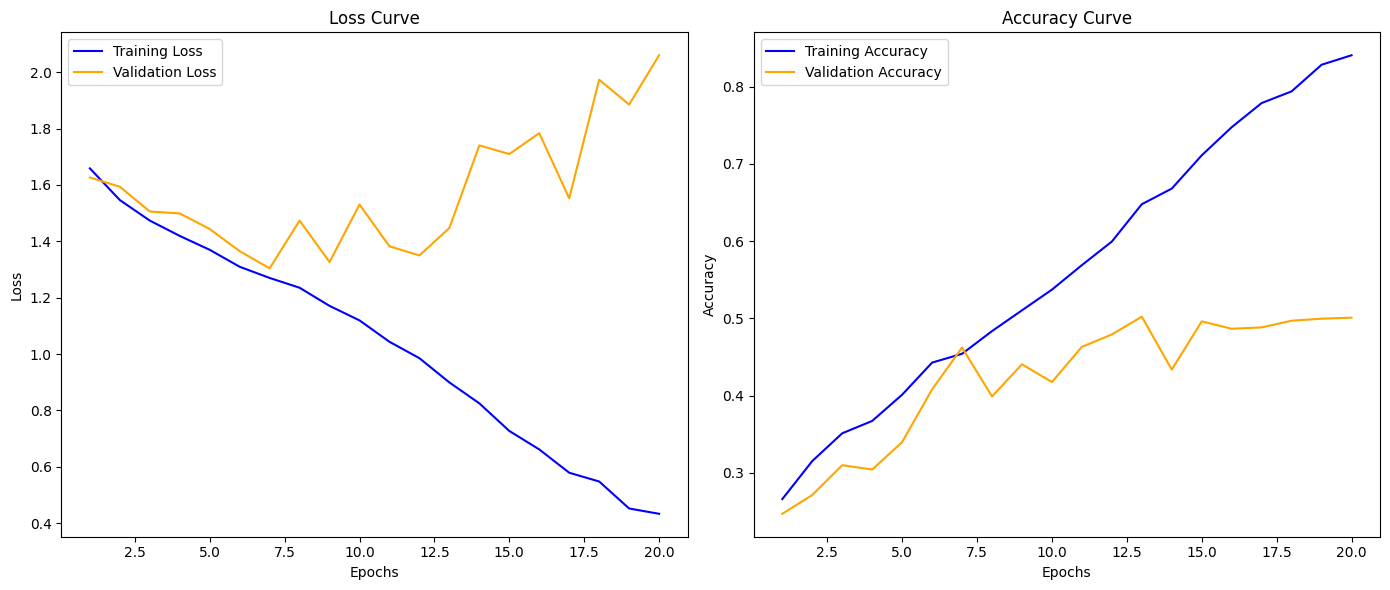

In [200]:
# Plot the loss and accuracy
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, epochs)

In [86]:
if not os.path.exists('COMP90086_2024_Project_test'):
    # Get training data
    file_id = '1zGQl6K0JiGfHeIINz5go3pUrExnniB-d'
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, 'test.zip', quiet=False)

    # Unzip data
    with zipfile.ZipFile('test.zip', 'r') as zip_ref:
        tqdm(zip_ref.extractall('COMP90086_2024_Project_test'))  # specify your extraction directory

    # Delete zip file
    os.remove('test.zip')

In [87]:
testPath = 'COMP90086_2024_Project_test'
testFile = 'test.csv'

test_filenames, _ = getFilenames(testPath, testFile, 'test')

1000 / 1920 : 525774
1920 / 1920 : 999651


In [88]:
# Create test dataset and dataloader
test_dataset = CustomCV2Dataset(test_filenames, [1] * len(test_filenames))  # Use the original validation data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [89]:
# Set model to evaluation mode
model.eval()

# Store predictions
predictions = []

# No need to calculate gradients during inference
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        images = images.float()  # Ensure the input is of type float32
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the index of the highest score
        predicted = predicted + 1
        predictions.extend(predicted.cpu().numpy())  # Store the predictions

# Now `predictions` will contain the predicted labels for the test images

In [90]:
pd.Series(predictions).value_counts()

1    523
2    446
3    354
4    295
5    212
6     90
Name: count, dtype: int64

In [91]:
test_path = os.path.join(testPath, testFile)
test_pred = pd.read_csv(test_path)
test_pred['stable_height'] = predictions
test_pred.set_index('id').to_csv('predictions.csv')